# Grand Hackathon d'IndabaX-Togo 2023: Défi de détection de fraude Xente

## Quelques défis identifiés (French):
- Le déséquilibre entre les classees ( seulement 2 sur 1000 trasactions sont fraud)
- La distrubtion des données peut evoluer  entre le jeu d'entrainement et de test final 

## Packages

In [6]:
import os, sys
import numpy as np
import pandas as pd 


In [7]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [8]:
from itertools import chain
import matplotlib.pyplot as plt

In [9]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_auc_score, average_precision_score,f1_score

from sklearn.ensemble import RandomForestClassifier as RF 

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


## Data & Processing

In [10]:
#os.listdir('Datasets')
data_path = 'Datasets/'
train_data = pd.read_csv(data_path+'training.csv',low_memory=False)
test_data = pd.read_csv(data_path+'test.csv',low_memory=False)


In [11]:
train_data['TransactionStartTime'] = train_data['TransactionStartTime'].str.replace('T', ' ')
train_data['TransactionStartTime'] = train_data['TransactionStartTime'].str.replace('Z', '')
test_data['TransactionStartTime'] = test_data['TransactionStartTime'].str.replace('T', ' ')
test_data['TransactionStartTime'] = test_data['TransactionStartTime'].str.replace('Z', '')

train_data['TransactionStartTime'] = pd.to_datetime(train_data['TransactionStartTime'], infer_datetime_format=True) 
test_data['TransactionStartTime'] = pd.to_datetime(test_data['TransactionStartTime'], infer_datetime_format=True) 

train_data['Year'] = train_data['TransactionStartTime'].dt.year
train_data['Month'] = train_data['TransactionStartTime'].dt.month
train_data['Day'] = train_data['TransactionStartTime'].dt.day
train_data['Hour'] = train_data['TransactionStartTime'].dt.hour
train_data['Minute'] = train_data['TransactionStartTime'].dt.minute
train_data['Seconds'] = train_data['TransactionStartTime'].dt.second
train_data['week'] = train_data['TransactionStartTime'].dt.week
train_data['weekday'] = train_data['TransactionStartTime'].dt.weekday

test_data['Year'] = test_data['TransactionStartTime'].dt.year
test_data['Month'] = test_data['TransactionStartTime'].dt.month
test_data['Day'] = test_data['TransactionStartTime'].dt.day
test_data['Hour'] = test_data['TransactionStartTime'].dt.hour
test_data['Minute'] = test_data['TransactionStartTime'].dt.minute
test_data['Seconds'] = test_data['TransactionStartTime'].dt.second
test_data['week'] = test_data['TransactionStartTime'].dt.week
test_data['weekday'] = test_data['TransactionStartTime'].dt.weekday

/tmp/ipykernel_37478/2370544504.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_data['week'] = train_data['TransactionStartTime'].dt.week
/tmp/ipykernel_37478/2370544504.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test_data['week'] = test_data['TransactionStartTime'].dt.week


In [12]:
selected_features = ['ProviderId','ProductId','ProductCategory','ChannelId','Amount','Value','PricingStrategy']
TransactionId_test = test_data.TransactionId.values
train_data = train_data[selected_features+["AccountId"]+["FraudResult"]]
test_data = test_data[selected_features]

In [13]:
train_data.FraudResult.mean()

0.00201752001839811

In [14]:
train_data.shape, test_data.shape,train_data.FraudResult.mean()

((95662, 9), (45019, 7), 0.00201752001839811)

In [15]:
Train_account = train_data.AccountId.unique()
n_unique_account = len(Train_account)
n_unique_account

3633

In [17]:
cat_features = ['ProviderId','ProductId','ProductCategory','ChannelId','PricingStrategy']
num_cols = ['Amount','Value']

In [18]:
test_data_copy = test_data.copy()

In [19]:
set_config(transform_output="pandas")
processor = ColumnTransformer(
    (
        ("numerical", StandardScaler(), num_cols),
        ("categorical",OneHotEncoder(sparse_output=False, drop="if_binary", handle_unknown="ignore"),cat_features)
    ),
    verbose_feature_names_out=False,
)

In [20]:
datasets = []
X_train = train_data
X_valid = train_data
Y_train = X_train.FraudResult.values
Y_valid = X_valid.FraudResult.values
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]

test_data = test_data_copy.copy()
X_train['ProviderId'] = X_train['ProviderId'].apply(lambda x: 1 if x in ['ProviderId_3','ProviderId_1'] else 0)
X_valid['ProviderId'] = X_valid['ProviderId'].apply(lambda x: 1 if x in ['ProviderId_3','ProviderId_1'] else 0)
test_data['ProviderId'] = test_data['ProviderId'].apply(lambda x: 1 if x in ['ProviderId_3','ProviderId_1'] else 0)

X_train['ProductId'] = X_train['ProductId'].apply(lambda x: 1 if x in ['ProductId_15'] else 0)
X_valid['ProductId'] = X_valid['ProductId'].apply(lambda x: 1 if x in ['ProductId_15'] else 0)
test_data['ProductId'] = test_data['ProductId'].apply(lambda x: 1 if x in ['ProductId_15'] else 0)

X_train['ProductCategory'] = X_train['ProductCategory'].apply(lambda x: 1 if x in ['financial_services'] else 0)
X_valid['ProductCategory'] = X_valid['ProductCategory'].apply(lambda x: 1 if x in ['financial_services'] else 0)
test_data['ProductCategory'] = test_data['ProductCategory'].apply(lambda x: 1 if x in ['financial_services'] else 0)

X_train = processor.fit_transform(X_train)
X_valid = processor.transform(X_valid)
test_data = processor.transform(test_data)

datasets.append((X_train,X_valid,Y_train,Y_valid, test_data))

/tmp/ipykernel_37478/1254494848.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ProviderId'] = X_train['ProviderId'].apply(lambda x: 1 if x in ['ProviderId_3','ProviderId_1'] else 0)
/tmp/ipykernel_37478/1254494848.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['ProviderId'] = X_valid['ProviderId'].apply(lambda x: 1 if x in ['ProviderId_3','ProviderId_1'] else 0)
/tmp/ipykernel_37478/1254494848.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [21]:
X_train,X_valid,Y_train,Y_valid, test_data = datasets[0]

In [22]:
X_train.head()

,Amount,Value,ProviderId_1,ProductId_1,ProductCategory_1,ChannelId_ChannelId_1,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4
0,-0.046371,-0.072291,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.054643,-0.080251,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.050426,-0.076352,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.107717,0.096648,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.059704,-0.075183,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
test_data.head()

,Amount,Value,ProviderId_1,ProductId_1,ProductCategory_1,ChannelId_ChannelId_1,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4
0,-0.046371,-0.072291,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.038261,-0.064169,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.054887,-0.080007,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.030151,-0.056047,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.054968,-0.079926,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
X_train.shape, X_valid.shape, Y_train.mean(), Y_valid.mean()

((95662, 13), (95662, 13), 0.00201752001839811, 0.00201752001839811)

In [25]:
Y_train.sum(),Y_valid.sum()

(193, 193)

In [26]:
train_data.shape,test_data.shape

((95662, 9), (45019, 13))

### Model 

In [38]:
static_params = {
                 'max_depth':4,
                 'n_estimators': 500,
                 'n_jobs': -1,
                 'random_state':42
                 

}

In [39]:
xgb_model = RF(**static_params)

In [40]:
X_train_, X_test_, Y_train_, Y_test_, test_data = datasets[0]

In [41]:
xgb_model.fit(X_train_, Y_train_)

RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [42]:
pred_final = [xgb_model.predict_proba(test_data)[:,1]]

In [43]:
pred_train  = xgb_model.predict_proba(X_train_)[:,1]

### Choice of the Tresh 

In [44]:
def Tresh_to_metric(y_true,pred_t, treshs):
    res = list()
    for tresh in treshs:
        pred_tresh = (pred_t>tresh).astype(int)
        res.append(f1_score(y_true,pred_tresh))
    return res

In [45]:
treshs = np.arange(0.3, 0.6, 0.005)
ress = Tresh_to_metric(Y_train_, pred_train,treshs)

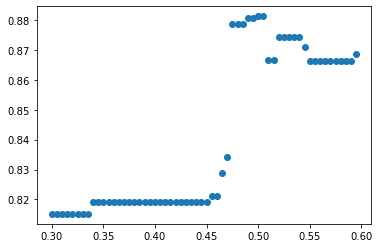

In [46]:
plt.scatter(treshs,ress);

In [47]:
pred_tresh = (pred_train>0.50).astype(int)

In [48]:
f1_score(Y_train_,pred_tresh)

0.8812664907651714

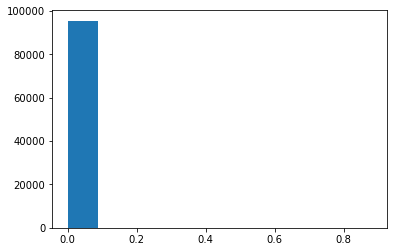

In [49]:
plt.hist(pred_train);

## Final submission

In [58]:
pred_f = pred_final[0]

In [59]:
submittions = pd.read_csv(data_path+'sample_submission.csv',low_memory=False)


In [60]:
submittions.head()

,TransactionId,FraudResult
0,TransactionId_50600,NaN
1,TransactionId_95109,NaN
2,TransactionId_47357,NaN
3,TransactionId_28185,NaN
4,TransactionId_22140,NaN


In [61]:
submittions.shape

(45019, 2)

In [62]:
TransactionId_test[:5]

array(['TransactionId_50600', 'TransactionId_95109',
       'TransactionId_47357', 'TransactionId_28185',
       'TransactionId_22140'], dtype=object)

In [63]:
# Create submission DataFrame
submission = pd.DataFrame({"TransactionId": TransactionId_test,
                           "FraudResult": (pred_f>0.5).astype(int)})

In [66]:
submission.to_csv('Results/submit_V2_all_train_same_ponderation_RF.csv', index = False)

In [67]:
(pred_f>0.5).astype(int).mean()

0.0016215375730247229

### Expert rules

In [69]:
submission = pd.read_csv('Results/submit_V2_all_train_same_ponderation_RF.csv')

In [70]:
id_pos_transac = ['TransactionId_59595',
 'TransactionId_87268',
 'TransactionId_9176',
 'TransactionId_114219',
 'TransactionId_87779',
 'TransactionId_26542']

In [71]:
id_neg_transac = ['TransactionId_112820',
 'TransactionId_123757',
 'TransactionId_70610',
 'TransactionId_84063']

In [72]:
submission[submission.TransactionId.isin(id_pos_transac)]

,TransactionId,FraudResult
17633,TransactionId_87268,0
17634,TransactionId_59595,0
19271,TransactionId_26542,0
19273,TransactionId_87779,0
19674,TransactionId_114219,0
19677,TransactionId_9176,0


In [73]:
submission[submission.TransactionId.isin(id_neg_transac)]

,TransactionId,FraudResult
23533,TransactionId_70610,1
24868,TransactionId_112820,1
24939,TransactionId_123757,1
39192,TransactionId_84063,1


In [74]:
submission.loc[submission.TransactionId.isin(id_neg_transac), 'FraudResult']=0
submission.loc[submission.TransactionId.isin(id_pos_transac),'FraudResult']=1

In [75]:
submission

,TransactionId,FraudResult
0,TransactionId_50600,0
1,TransactionId_95109,0
2,TransactionId_47357,0
3,TransactionId_28185,0
4,TransactionId_22140,0
...,...,...
45014,TransactionId_116198,0
45015,TransactionId_24829,0
45016,TransactionId_102920,0
45017,TransactionId_128439,0


In [76]:
submission[submission.TransactionId.isin(id_neg_transac)]

,TransactionId,FraudResult
23533,TransactionId_70610,0
24868,TransactionId_112820,0
24939,TransactionId_123757,0
39192,TransactionId_84063,0


In [77]:
submission.to_csv('Results/submit_V2_all_train_same_ponderation_RF_manuelset.csv', index = False)

### TO DO add more expert example